## `NON-DETERMINISTIC` Interpolator, $I_{\phi}$, Evaluation.

* Exploring the effects of dropout on the interpolators. In particular, taking a look at the CRPS and distributions of predictions when `dropout != 0.0`.

* Analysis on how much influence the dropout rate has on making more diverse ensembles (higher SSR)


In [1]:
import os
from pathlib import Path
from typing import Dict, Optional, Tuple

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from omegaconf import OmegaConf
from scipy import io
import torch
from torch.utils.data import DataLoader

from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.dyffusion.experiment_types.interpolation import InterpolationExperiment
from rainnow.src.interpolator_evaluation import (
    crps_metrics,
    get_an_interpolated_ensemble_batch,
    plot_interpolated_batch,
    plot_interpolation_ensemble,
    ssr_metrics,
)
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import (
    instantiate_interpolator_model_ckpt_from_config,
    load_imerg_datamodule_from_config,
    load_model_checkpoint_for_eval,
)
from rainnow.src.utilities.utils import (
    enable_inference_dropout,
    get_device,
)

#### `helpers.`

In [4]:
# ** DIR helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CKPT_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/results/interpolation_experiments"
CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# plotting helpers.
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")

rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {
    "font.size": 10,
    # "font.family": "Times New Roman",
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
}
plt_params = {"wspace": 0.2, "hspace": 0.2}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 10}

# get device.
device = get_device()

#### `instantiate the dataloaders + get batch of data.`

In [5]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        # change this depending on what models you're testing.
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)
# datamodule.setup("fit")
# datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

# set up the dataloaders.
BATCH_SIZE = datamodule.hparams["batch_size"]
# train_dataloader = DataLoader(datamodule._data_train, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(datamodule._data_val, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(datamodule._data_test, batch_size=BATCH_SIZE, shuffle=False)
predict_dataloader = DataLoader(datamodule._data_predict, batch_size=BATCH_SIZE, shuffle=False)

[2024-08-29 12:46:12][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 12:46:12][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-29 12:48:25][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-08-29 12:48:25][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 12:48:25][abstract_datamodule.py][INFO] -->  Dataset test size: 851
[2024-08-29 12:48:25][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 12:48:25][imerg_precipitation.py][INFO] --> predict data split: [202303080000, 202303100000]
[2024-08-29 12:50:36][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-08-29 12:50:36][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 12:50:36

In [6]:
# get a batch of data.
iter_loader = iter(predict_dataloader)
X = next(iter_loader)["dynamics"]

# debug info.
print(f"\n**  batch size = {BATCH_SIZE} **")
print(f"** num batches = {len(iter_loader)} **")
print(f"** num samples = {BATCH_SIZE * len(iter_loader)} ** ")
print(f"** sample dims: {X.shape}")  # (batch_size, sequence_length, channels, H, W)
print(f"** loaded sequence length = {datamodule.hparams.horizon + datamodule.hparams.window} **")


**  batch size = 6 **
** num batches = 2 **
** num samples = 12 ** 
** sample dims: torch.Size([6, 9, 1, 128, 128])
** loaded sequence length = 9 **


#### `instantiate PreProcess() object`

In [8]:
# instantiate the pprocessor object.
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-29 12:50:36][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


#### `Loss Function Experimental Setup w/ dp:`

* model = `Unet Resnet`
* number of epochs = `15` unless stated otherwise i.e. in the `experiment description` value of the dict.
* lr = `0.001 (1e-3)`
* grid box = `[1, 0]`
* all data is Min Max + Log Linear Normed via `PreProcess()`
* batch size = **6**
* For all pixel-based distance losses (MSEs) the `reduction = 'mean'` unless stated otherwise.
* num ensemble = **6**
* DROPOUTs are stated in the `ckpt_dict`.
* Batchnorm used throughout UNet unless stated otherwise.
* Final Conv Layer Kernel Size = **4**

**NOTE**: YOU need to add a model's `ckpt_id` to the `ckpt_dict` for it to work with the evaluation functionality.

In [9]:
ckpt_dict = {
    # ** 15 epoch trains. **
    # ** 1/2 sequence length **
    # ** Batchnorm UNet final kernel Size = 4 **
    # LPIPS.
    "ipol-j9ba5lap": "LCB(α=.6) | dp:(0, .1, .3, .3)",
    "ipol-azpen1vk": "LCB(α=.6) | dp:(0, .2, .6, .6)",  # .33 LIPS (same IDs).
    # "ipol-azpen1vk": "LCB(α=.33) | dp:(0, .2, .6, .6)",
    "interpolation-lopmudym": "LCB(α=.6) dp:(.3, .2, .6, .6)",
    "interpolation-k71rkbd0": "LCB(α=.6) | dp:(.2, .4, .7, .7)",
    "interpolation-xggwevja": "LCB(α=.6) | dp:(.3, .2, .7, .7)",
    "interpolation-j7a41vfh": "LCB(α=.6) dp:(.4, .1, .3, .3)",
    "interpolation-yywxun9p": "LCB(α=.6) dp:(.4, .3, .7, .3)",
    "interpolation-nhax1bxg": "LCB(α=.6) dp:(.4, .3, .7, .8)",
    "interpolation-yn6mloms": "LCB(α=.6) | dp:(.4, .6, .85, .85)",  # .33 LIPS (same IDs).
    # "interpolation-yn6mloms": "LCB(α=.33) | dp:(.4, .6, .85, .85)",
    "interpolation-ifq0zic8": "LCB(α=.6) | dp:(.6, .4, .8, .8)",  # .33 LIPS (same IDs).
    # "interpolation-ifq0zic8": "LCB(α=.33) | dp:(.6, .4, .8, .8)",
    "interpolation-5eurdqhf": "LCB(α=.6) | dp:(.75, .75, .9, .9)",  # .33 LIPS (same IDs).
    # "interpolation-5eurdqhf": "LCB(α=.33) | dp:(.75, .75, .9, .9)",            # very high dropout.
    # .4, .3, .7, .8 @ different α (.33, & .9).
    "interpolation-p32wzr6p": "LCB(α=.9) | dp:(.3, .2, .6, .6)",
    "interpolation-aw7aqmu6": "LCB(α=.9) | dp:(.4, .3, .7, .8)",
    "interpolation-otiknefi": "LCB(α=.33) | dp:(.4, .3, .7, .8)",
    "interpolation-pzsmwjnb": "LCB(α=.33) | dp:(.2, .4, .8, .8)",
    "interpolation-17hdeuvx": "LCB(α=.33) | dp:(.7, .1, .3, .7)",
    "ipol-vluyjfsx": "LCB(α=.33) | dp:(0, .1, .3, .3)",
    "interpolation-h3liisur": "LCB(α=.33) | dp:(0, .3, .7, .7)",
    # "interpolation-pzsmwjnb": "LCB(α=.33) | dp:(.2, .4, .8, .8)",
    # "interpolation-b3g613b1": "LCB(α=.33) | 2Ddp:(.2, .4, .8, .8)",
    # "interpolation-7ut2c9um": "LCB(α=.33) | dp:(.8, .8, .95, .95) + 1Conv",  # swithed off double convolution.
    # WL.
    "ipol-qpb60edp": "WL(ε=150.) | dp: (0, .1, .3, .3)",
    "ipol-bdslymv0": "WL(ε=150.) | dp: (0, .2, .6, .6)",
    "interpolation-imrvuhnn": "WL(ε=150.) | dp: (3, .2, .6, .6)",
    "interpolation-zmka6woq": "WL(ε=150.) | dp: (4, .1, .3, .3)",
    "interpolation-zsuynpxh": "WL(ε=150.) | dp: (.4, .3, .7, .8)",
    "interpolation-f0vdlcu8": "WL(ε=150.) | dp: (.4, .3, .7, .7) + DataAug",  # added 50% of the data reversed to the training data.
    "interpolation-uvnsokn0": "WL(ε=150.) | dp: (.6, .2, .6, .6)",
    # # ** 40 epoch trains **
    # # MSE.
    # "ipol-odlf3ns1": "MSE w/ dp: (.1, .3, .3) + 40E",
    # # WL.
    # "ipol-6bxbyvw4": "WL(ε=150.) | dp: (0, .1, .3, .3) + 40E",
    # "interpolation-1imzfyqz": "WL(ε=150.) | dp: (.4, .3, .7, .7) 40E",
    # # LPIPS.
    # "ipol-ppzim4b2": "LCB(α=.33) | dp:(0, .1, .3, .3) + 40E",
    # "ipol-sv3ewz2e": "LCB(α=.33) | dp:(0, .2, .6, .6) + 40E",
    # "ipol-znmlqb7i": "LCB(α=.6) | dp:(0, .1, .3, .3) + 40E",
    # "ipol-bb4qhjxx": "LCB(α=.6) | dp:(0, .2, .6, .6) + 40E",
    # "ipol-8b6ffkzr": "LCB(α=.6) | dp:(.2, .2, .6, .6) + 40E",
    # # "ipol-yccodrh2": "LCB(α=.6) | dp:(.2,.6,.6) E40+32(7e-5)+20(7e-5)",      # pushed training.
    # "interpolation-fe2swqvq": "LCB(α=.33) | dp:(.4, .3, .7, .8) + 40E",
    # # ** full sequence **
    # "interpolation-sr8w8jme": "(1-.33)*LPIPS+.33*CB w/ dp:(.4, .3, .7, .8) Full Seq.",
    # "interpolation-xuixxwql": "(1-.33)*LPIPS+.33*CB w/ dp:(.4, .3, .7, .8) 15E + Full Seq. + Lnorm + FKS=5",   # 'more complex' UNet.
    # "interpolation-ljz5plbq": "(1-.33)*LPIPS+.33*CB w/ dp:(.4, .3, .7, .8) 40E + Full Seq. + Lnorm + FKS=5",   # 'more complex' UNet.
    # "interpolation-e1q8oagq": "interpolation-ljz5plbq + 20E",                                                  # 'more complex' UNet.
    # "interpolation-kkjrskfd": "WL(ε=150.) w/ dp: (.3, .4, .7, .8) 40E + Full Seq + Lnorm + FKS=5.",            # 'more complex' UNet.
    # final trains.
    "interpolation-lndwhf39": "LCB(α=.6) | dp:(.3, .2, .6, .6) + 40E + entire dataset.",  # LPIPS
    "interpolation-cc2yoiyi": "interpolation-lndwhf39 + 30E @ LR=3e-4",
    "interpolation-pmfexw2m": "L1 (MAE) | dp:(.3, .2, .6, .6) + 40E + entire dataset.",  # MAE
}

#### `Load in an interpolator model(s) (UNet ResNet or Unet) for evaluation`

In [ ]:
# # use this to choose what models you want to compare.
# ckpt_ids = []
loaded_models = {}
# for ckpt_id in ckpt_dict.keys():
for ckpt_id in ["interpolation-pmfexw2m", "interpolation-lndwhf39", "interpolation-cc2yoiyi"]:
    print(f"** Getting model from ckpt_id: {ckpt_id} **\n")
    # instantiate.
    model = instantiate_interpolator_model_ckpt_from_config(
        ckpt_id=ckpt_id,
        model_ckpt_cfg_base_path=CKPT_BASE_PATH,
        cfg_base_path=CONFIGS_BASE_PATH,
        model_cfg_name=CKPT_CFG_NAME,
        datamodule_cfg_name=DATAMODULE_CONFIG_NAME,
    )
    # load w&b.
    model = load_model_checkpoint_for_eval(
        model=model, ckpt_id=ckpt_id, ckpt_base_path=CKPT_BASE_PATH, ckpt_dir=CKPT_DIR, get_last=GET_LAST
    )

    # enable monte-carlo randomness in dropout layers during inference.
    enable_inference_dropout(model)

    loaded_models[ckpt_id] = model

In [11]:
# ** LEAVE here **.
def get_eval_plot_inputs(X, batch_num, num_ensemble, non_zero_thd, ckpt_id, loaded_models, pprocessor):
    """Wrapper function to get eval inputs for plotting."""
    # get an ensemble of interpolations + targets.
    X_raw, X_reversed, ens_interp_ts, ens_interp_ts_reversed = get_an_interpolated_ensemble_batch(
        inputs=X,
        pprocessor_obj=pprocessor,
        model=loaded_models[ckpt_id],
        batch_num=batch_num,
        num_ens_preds=num_ensemble,
    )
    targets = X_raw[1:-1, ...].squeeze(dim=1).detach().cpu().numpy()
    targets_reversed = X_reversed[1:-1, ...].squeeze(dim=1).detach().cpu().numpy()
    # reshape to get desired shape for ensembles.
    ensemble_predictions = (
        torch.stack(ens_interp_ts).swapdims(dim0=0, dim1=1).squeeze(2).detach().cpu().numpy()
    )
    ensemble_predictions_reversed = (
        torch.stack(ens_interp_ts_reversed).swapdims(dim0=0, dim1=1).squeeze(2).detach().cpu().numpy()
    )
    # get 'non-zero' ensemble.
    mask = targets > non_zero_thd
    ens_mask = np.repeat(mask.reshape(1, *mask.shape), num_ensemble, axis=0)
    ensemble_predictions_masked = ensemble_predictions[ens_mask].reshape(num_ensemble, -1)
    # crps scores.
    crps_pp, crps_raw, crps_nonzero = crps_metrics(
        ensemble_predictions=[
            ensemble_predictions,
            ensemble_predictions_reversed,
            ensemble_predictions_masked,
        ],
        targets=[targets, targets_reversed, targets[mask]],
        mean_crps=True,
    )

    # ssr scores.
    ssr_pp, ssr_raw, ssr_nonzero = ssr_metrics(
        ensemble_predictions=[
            ensemble_predictions,
            ensemble_predictions_reversed,
            ensemble_predictions_masked,
        ],
        targets=[targets, targets_reversed, targets[mask]],
    )

    return (
        X_raw,
        X_reversed,
        ens_interp_ts,
        ens_interp_ts_reversed,
        targets,
        [crps_pp, crps_raw, crps_nonzero],
        [ssr_pp, ssr_raw, ssr_nonzero],
    )

### `NON-DETERMINISTIC` Ensemble Evaluation:

In [12]:
NUM_ENS_PREDS = 8
NUM_INTERPOLATIONS = X.size(1) - 2
NON_ZERO_THD = 0.1
print(f"** Eval w/ Num Ens Preds={NUM_ENS_PREDS} for {NUM_INTERPOLATIONS} interps **")
print(f"** using threshold={NON_ZERO_THD} to explore the non-zero distributions **")

** Eval w/ Num Ens Preds=8 for 7 interps **
** using threshold=0.1 to explore the non-zero distributions **


In [13]:
BATCH_NUM_TO_PLOT = 0

** model desc: interpolation-lndwhf39 + 30E @ LR=3e-4 **

plotting interpolation ensemble for t=1
plotting interpolation ensemble for t=2
plotting interpolation ensemble for t=3
plotting interpolation ensemble for t=4
plotting interpolation ensemble for t=5
plotting interpolation ensemble for t=6
plotting interpolation ensemble for t=7


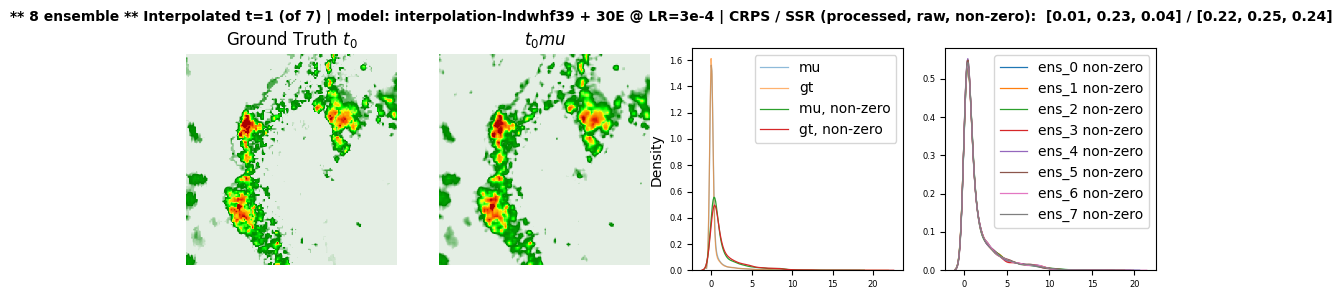

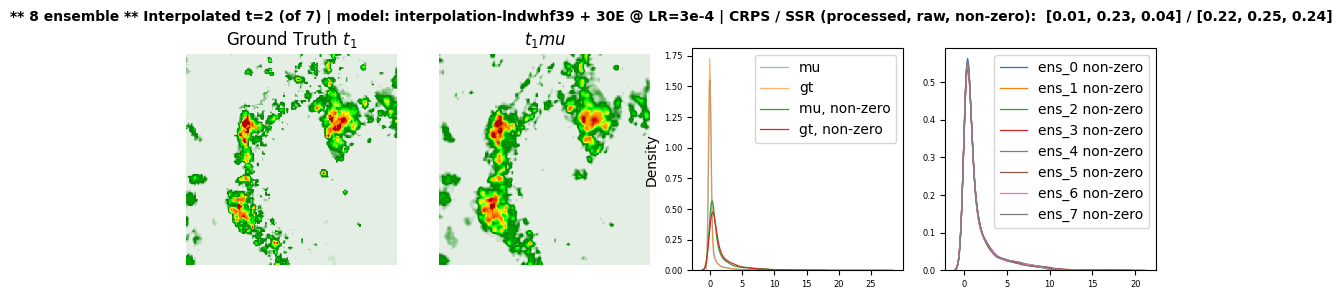

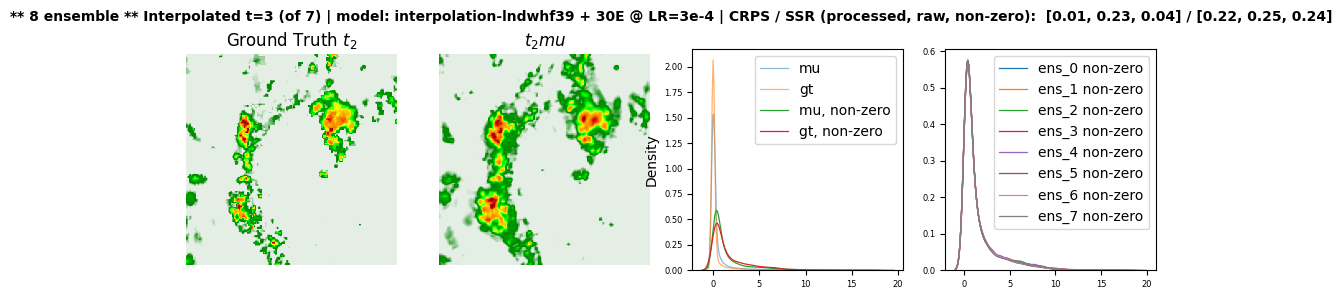

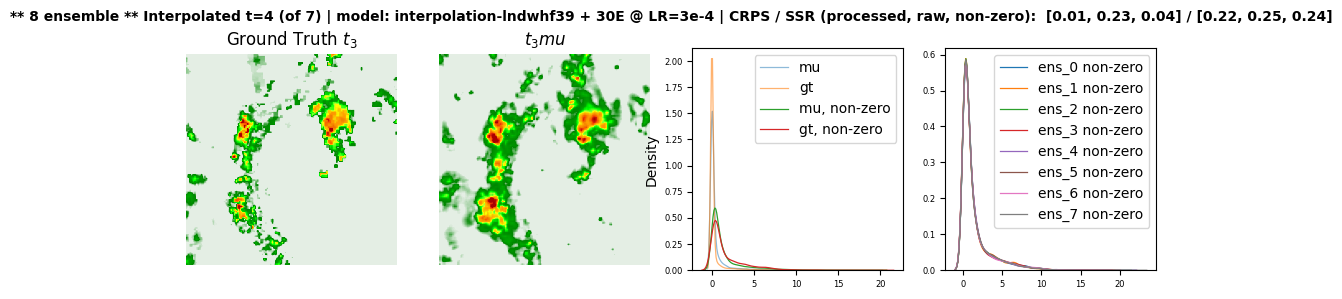

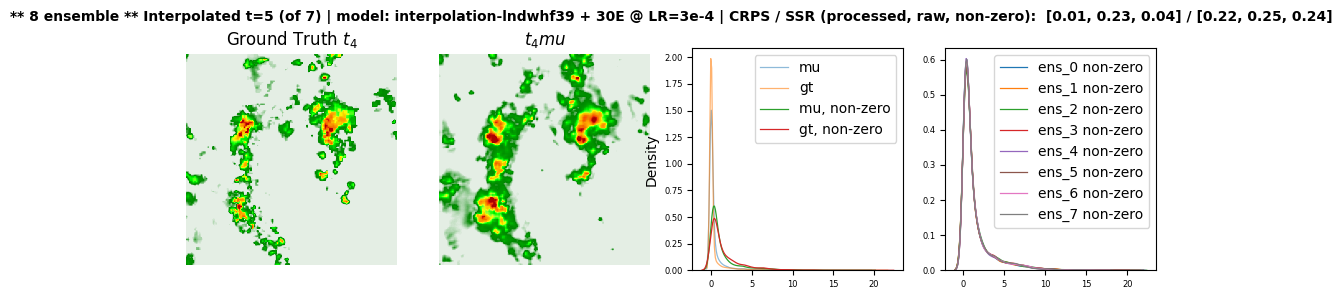

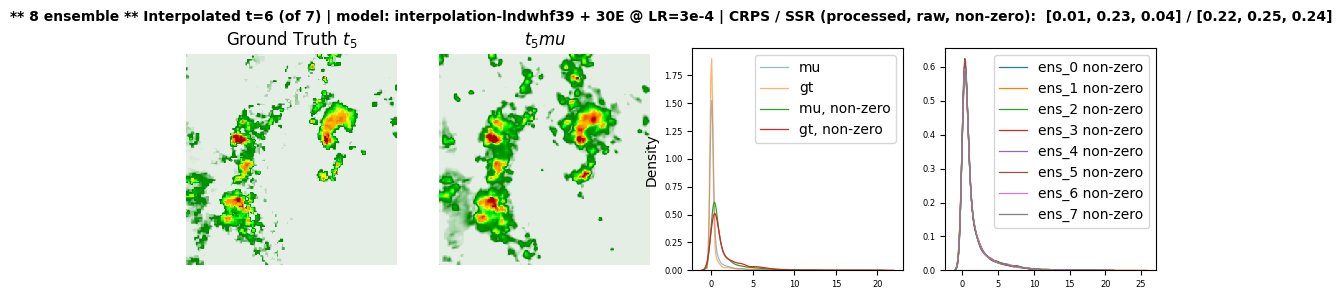

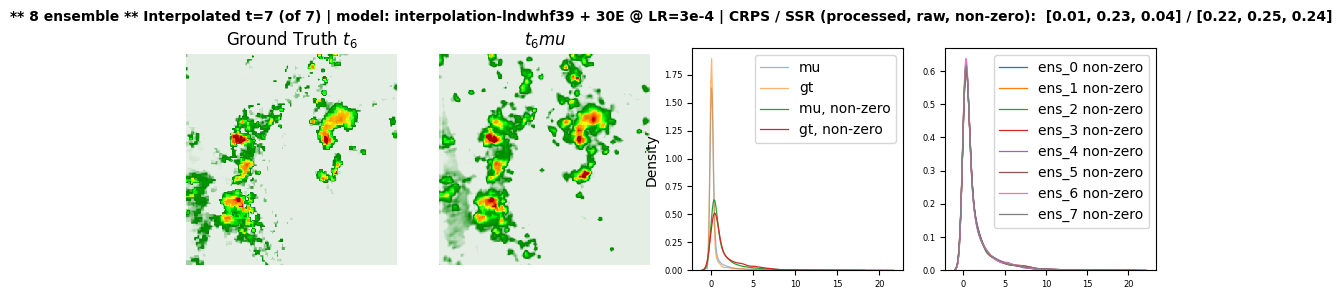

In [18]:
ckpt_id = "interpolation-cc2yoiyi"
print(f"** model desc: {ckpt_dict[ckpt_id]} **\n")
X_raw, X_reversed, ens_interp_ts, ens_interp_ts_reversed, targets, _crps, _ssr = get_eval_plot_inputs(
    X=X,
    batch_num=BATCH_NUM_TO_PLOT,
    num_ensemble=NUM_ENS_PREDS,
    non_zero_thd=NON_ZERO_THD,
    ckpt_id=ckpt_id,
    loaded_models=loaded_models,
    pprocessor=pprocessor,
)

for t in range(len(targets)):
    print(f"plotting interpolation ensemble for t={t + 1}")
    plot_interpolation_ensemble(
        ensemble_interpolations=ens_interp_ts_reversed,
        targets=X_reversed,
        t_to_plot=t,
        model_desc=ckpt_dict[ckpt_id],
        crps=_crps,
        ssr=_ssr,
        plot_ensemble=False,
        plot_ens_zero=False,
        non_zero_thd=NON_ZERO_THD,
        channel_to_plot=0,
        global_params=global_params,
        plot_params={"cmap": rain_cmap, "vmin": 0.1, "vmax": 10},
        layout_params=plt_params,
        kde_linewidth=0.9,
        figsize=(10, 3),
    )

In [ ]:
plot_interpolated_batch(
    targets=X_reversed,
    preds=np.array(ens_interp_ts_reversed).mean(axis=1),
    c=0,
    figsize=(18, 4),
    plot_title=True,
    global_params={"font.size": 6},
    layout_params={"wspace": 0.1, "hspace": 0.1},
    plot_params={"cmap": rain_cmap, "vmin": 0.1, "vmax": 10},
)

### `Plots for MSc Research:`

* plots used for the `IRP report`. They are geoplots that include country boundaries and coastlines.

/var/folders/1k/vm_h9ycj6d9020w63h786g5w0000gp/T/ipykernel_5221/4284099169.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _mae = torch.mean(np.abs(torch.mean(ens_interp, dim=0)[0, ...] - gt))


plotting idx: 4
plotting idx: 7
plotting idx: 0
plotting idx: 2


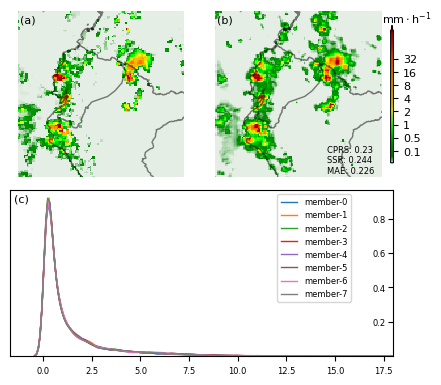

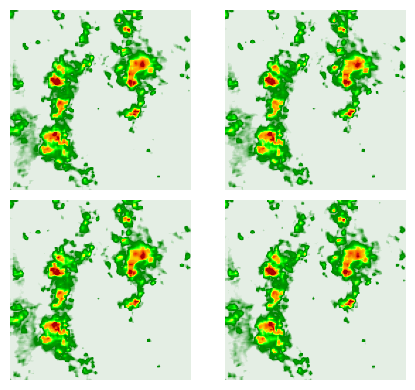

In [17]:
targets = X_reversed
t_to_plot = 5
channel_to_plot = 0
kde_linewidth = 1
non_zero_thd = 0.1
num_ens_preds = NUM_ENS_PREDS
ensemble_interpolations = ens_interp_ts_reversed
ens_interp = ensemble_interpolations[t_to_plot]
cmap = rain_cmap

fig = plt.figure(figsize=(4.5, 4))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

plt.rcParams.update(**{"font.size": 12, "xtick.labelsize": 6, "ytick.labelsize": 6})

# # First row: Ground Truth and Mean Prediction
# ax1 = fig.add_subplot(gs[0, 0])
# gt = targets[t_to_plot, channel_to_plot, :, :]
# ax1.imshow(gt, cmap=cmap, vmin=.5, vmax=10)

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
gt = targets[t_to_plot, channel_to_plot, :, :]
ax1.set_extent([-83.55, -70.75, -8.75, 4.05], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, alpha=0.5)
ax1.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1, alpha=0.5)
lons = np.linspace(-83.55, -70.75, 128)
lats = np.linspace(-8.75, 4.05, 128)
lon_grid, lat_grid = np.meshgrid(lons, lats)
im = ax1.pcolormesh(
    lon_grid,
    lat_grid,
    np.flipud(gt),
    transform=ccrs.PlateCarree(),
    cmap=rain_cmap,
    vmin=0.1,
    vmax=10,
)
# ax1.set_title(f"Ground Truth", fontsize=10)
ax1.axis("off")
ax1.text(0.01, 0.975, "(a)", transform=ax1.transAxes, fontsize=8, va="top", ha="left")

# ax2 = fig.add_subplot(gs[0, 1])
# mu_ens = torch.mean(ens_interp, dim=0)
# img = ax2.imshow(mu_ens[0, :, :], cmap=cmap, vmin=.5, vmax=10)

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
mu_ens = torch.mean(ens_interp, dim=0)
ax2.set_extent([-83.55, -70.75, -8.75, 4.05], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, alpha=0.5)
ax2.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1, alpha=0.5)
lons = np.linspace(-83.55, -70.75, 128)  # got [1,0]
lats = np.linspace(-8.75, 4.05, 128)
lon_grid, lat_grid = np.meshgrid(lons, lats)
img = ax2.pcolormesh(
    lon_grid,
    lat_grid,
    np.flipud(mu_ens[0, :, :]),
    transform=ccrs.PlateCarree(),
    cmap=rain_cmap,
    vmin=0.1,
    vmax=10,
)


# ax2.set_title(r"Interpolated$_{mean}$", fontsize=10)
ax2.axis("off")
ax2.text(0.01, 0.975, "(b)", transform=ax2.transAxes, fontsize=8, va="top", ha="left")

cbar = plt.colorbar(
    img, ax=ax2, orientation="vertical", pad=0.05, **{"fraction": 0.015, "aspect": 50, "extend": "max"}
)
cbar.set_ticks(np.arange(1, 9, 1))
cbar.set_ticklabels(["0.1", "0.5", "1", "2", "4", "8", "16", "32"], fontsize=8)
cbar.ax.text(
    6,
    1.05,
    r"$\text{mm}\cdot\text{h}^{-1}$",
    transform=cbar.ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=8,
)

_mae = torch.mean(np.abs(torch.mean(ens_interp, dim=0)[0, ...] - gt))
metrics_text = f"CPRS: {round(_crps[1], 3)}\nSSR: {round(_ssr[1], 3)}\nMAE: {round(_mae.item(), 3)}"
ax2.text(
    0.675,
    0.01,
    metrics_text,
    transform=ax2.transAxes,
    fontsize=6,
    verticalalignment="bottom",
    bbox=dict(facecolor="none", alpha=0.7, edgecolor="none"),
)

# Second row: KDE plot spanning both columns
ax3 = fig.add_subplot(gs[1, :])
plt.rcParams.update(**global_params)
for j in range(num_ens_preds):
    _interp_t = ens_interp[j, channel_to_plot, :, :]
    sns.kdeplot(
        _interp_t[_interp_t > non_zero_thd].flatten(),
        bw_adjust=0.5,
        ax=ax3,
        label=f"member-{j}",
        linewidth=kde_linewidth,
    )
ax3.yaxis.set_ticks_position("right")
ax3.yaxis.set_tick_params(direction="in", pad=-15)
ax3.set_yticks([0.2, 0.4, 0.6, 0.8])
ax3.legend(loc="upper right", bbox_to_anchor=(0.9, 1), fontsize=6)
ax3.text(0.01, 0.975, "(c)", transform=ax3.transAxes, fontsize=8, va="top", ha="left")
# ax3.legend(loc="best", fontsize=6)
ax3.set_ylabel("")
ax3.set_xlim(xmax=18)
plt.tight_layout()
plt.subplots_adjust(**{"wspace": 0.1, "hspace": 0.08})

# plot a 2x2 grid of ensemble plots.
base_col = 2
total_rows = (ensemble_interpolations[0].size(0) // base_col) + 1  # keep +1 to access axs[i, j].
fig, axs = plt.subplots(2, 2, figsize=(4.5, 4))
plt.rcParams.update(**global_params)
k = 0


for e, (i, j) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    rand_idx = np.random.randint(0, ens_interp.size(0))
    print(f"plotting idx: {rand_idx}")
    _interp_t = ens_interp[rand_idx, channel_to_plot, :, :]
    axs[i, j].imshow(_interp_t, cmap=cmap, vmin=0.1, vmax=10)
    axs[i, j].axis("off")

plt.tight_layout()
plt.subplots_adjust(**{"wspace": 0.05, "hspace": 0.05})

### `Comments`:
* As expected, the higher dropout models are more stochastic with the main randomness coming from higher dropouts in the input layer.

* The randomness is mainly in the positions of higher magnitude rain as opposed to rain shape. This means our ensembles do not differ greatly from the initial *t* in terms of overall position.

* No set of tested dropouts leads to any sort of `hallucinations` which we want.

* Unless input dropout is added, the SSR of the ensemble predictions is too overconfident.

* If the dropouts get too extreme, the model tends to under or over -estimate rainfall (too much information loss).

* Looking at the LPIPS interpolation validation plots for both dropout scenarios, the larger dropout is definitely generalising better.

* The "middle" interpolation is performing the worst. We expect it to do worse as its the furthest away from `x0` and `xh` but maybe with more dropout we can improve it.

* Looking at the validation 'training' plots, as expected with higher dropout we have much more convergent graphs.

* As shown many times, the interpolations when MSE is used as the model's loss functions are much worse than LPIPS or WL.

* The interesting find, especially for `t1` is that because it predicts so many 0's the distributions match more closely than WL and LPIPS with lower CRPS scores.

* Looking at the non-zero CRPS, the MSE is the worst performing model - as expected.

### END OF SCRIPT.